# Разработка A/B-тестирования и анализ результатов

# Описание данных

Будем работать с тремя датасетами:

* **`sessions_project_history.csv`** — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23.

* **`sessions_project_test_part.csv`** — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.

* **`sessions_project_test.csv`** — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц **`sessions_project_history.csv`**, **`sessions_project_test.csv`**, **`sessions_project_test_part.csv`**:

* **`user_id`** — идентификатор пользователя;

* **`session_id`** — идентификатор сессии в приложении;

* **`session_date`** — дата сессии;

* **`session_start_ts`** — дата и время начала сессии;

* **`install_date`** — дата установки приложения;

* **`session_number`** — порядковый номер сессии для конкретного пользователя;

* **`registration_flag`** — является ли пользователь зарегистрированным;

* **`page_counter`** — количество просмотренных страниц во время сессии;

* **`region`** — регион пользователя;

* **`device`** — тип устройства пользователя;

* **`test_group`** — тестовая группа (в таблице с историческими данными этого столбца нет).


# Содержимое проекта

* [1. Работа с историческими данными (EDA)](#1.-Работа-с-историческими-данными-(EDA))
    * [1.1. Загрузка исторических данных](#1.1.-Загрузка-исторических-данных)
    * [1.2. Знакомство с данными](#1.2.-Знакомство-с-данными)
    * [1.3. Анализ числа регистраций](#1.3.-Анализ-числа-регистраций)
    * [1.4. Анализ числа просмотренных страниц](#1.4.-Анализ-числа-просмотренных-страниц)
    * [1.5. Доля пользователей, просмотревших более четырёх страниц](#1.5.-Доля-пользователей,-просмотревших-более-четырёх-страниц)
* [2. Подготовка к тесту](#2.-Подготовка-к-тесту)
    * [2.1 Формулировка нулевой и альтернативной гипотез](#2.1-Формулировка-нулевой-и-альтернативной-гипотез)
    * [2.2. Расчёт размера выборки](#2.2.-Расчёт-размера-выборки)
    * [2.3. Расчёт длительности A/B-теста](#2.3.-Расчёт-длительности-A/B-теста)
* [3. Мониторинг А/В-теста](#3.-Мониторинг-А/В-теста)
    * [3.1. Проверка распределения пользователей](#3.1.-Проверка-распределения-пользователей)
    * [3.2. Проверка пересечений пользователей](#3.2.-Проверка-пересечений-пользователей)
    * [3.3. Равномерность разделения пользователей по устройствам](#3.3.-Равномерность-разделения-пользователей-по-устройствам)
    * [3.4. Равномерность распределения пользователей по регионам](#3.4.-Равномерность-распределения-пользователей-по-регионам)
    * [3.5. Вывод после проверки A/B-теста](#3.5.-Вывод-после-проверки-A/B-теста)
* [4. Проверка результатов A/B-теста](#4.-Проверка-результатов-A/B-теста)
    * [4.1. Получение результатов теста и подсчёт основной метрики](#4.1.-Получение-результатов-теста-и-подсчёт-основной-метрики)
    * [4.2. Проверка корректности результатов теста](#4.2.-Проверка-корректности-результатов-теста)
    * [4.3. Сравнение доли успешных сессий](#4.3.-Сравнение-доли-успешных-сессий)
    * [4.4. Насколько статистически значимо изменение ключевой метрики](#4.4.-Насколько-статистически-значимо-изменение-ключевой-метрики)
    * [4.5. Вывод по результатам A/B-эксперимента](#4.5.-Вывод-по-результатам-A/B-эксперимента)

# Задача проекта

Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

---

# 1. Работа с историческими данными (EDA)

## 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

Для начала импортируем необходимые для дальнейшей работы библиотеки

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

from math import ceil

from scipy import stats as st
from scipy.stats import mannwhitneyu

In [2]:
# Загружаем исторические данные о сессиях пользователях из CSV-файла в датафрейм 'sessions_history'
sessions_history = pd.read_csv('sessions_project_history.csv')

# Выводим на экран первые 5 строк полученного датафрейма
display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [3]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


In [4]:
sessions_history.describe()

,session_number,registration_flag,page_counter
count,435924.000000,435924.000000,435924.000000
mean,2.382908,0.077325,3.005561
std,1.288487,0.267107,1.024625
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,3.000000
75%,3.000000,0.000000,4.000000
max,10.000000,1.000000,7.000000


* Данные выглядят нормально:
    * выбросов нет
    * типы данных соответствуют содержимому
    * пропусков нет
    * названия столбцов соответствуют содержимому и выполнены в едином стиле
    
    ---

## 1.2. Знакомство с данными

In [5]:
# В датафрейм 'sessions_count' сохраним все 'user_id' и количество уникальных сессий
sessions_count = sessions_history.groupby(['user_id'])['session_id'].nunique().reset_index().sort_values(by='session_id', ascending=False)
display(sessions_count)

,user_id,session_id
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
72346,8A60431A825D035B,9
109383,D11541BAC141FB94,9
47956,5BCFE7C4DCC148E9,9
...,...,...
15859,1DF13BB1953B3497,1
51449,628502A3CE7E0A3C,1
15853,1DEEF40DEFBD0C65,1
89905,AC08479B7472C628,1


Получили двух пользователей с равным  (максимальным) количеством уникальных сессий.   
Выведем все данные из таблицы **`sessions_history`** с **`user_id`** первого по списку пользователя.

In [6]:
# Выводим все строки из датафрейма 'sessions_history' по пользователю с user_id '10E0DEFC1ABDBBE0', он же первый в списке 'sessions_count'
sessions_history[sessions_history['user_id'] == sessions_count['user_id'].iloc[0]]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Пользователь заходил с 14 по 25 августа, за исключением 21 и 23 чисел. Сессии нумеруются последовательно в столбце **`session_number`**, количество просмотренных страниц записываются отдельно для каждой сессии в столбец **`page_counter`**.   

Также видим, что за этот период пользователь так и не зарегистирировался (**`0`** в столбце **`registration_flag`**), заходил только из региона **`CIS`** с устройства **`Android`**.     

Кроме того мы видим только время начала сесиии (столбец **`session_start_ts`**), но о длительности сессии никакой информации нет, за исключением количества просмотренных страниц.

---

## 1.3. Анализ числа регистраций

* Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения.
* Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням.
* Построим линейный график доли зарегистрированных пользователей от всех пользователей по дням.

Создадим датафрейм **`registrations`**, в котором сохраним рассчитанные числа:   
* уникальные пользователи (**`dau_total`**),
* уникальные зарегистрированные пользователи (**`dau_registered`**),
* доля зарегистрированных пользователей от всех пользователей (**`dau_registered_rate`**).

Все данные сгруппируем по дням.

In [7]:
# Создаем датафрейм 'registrations', считаем число уникальных пользователей и число зарегистрированных пользователей,
# сгруппировав данные по дням наблюдения
registrations = sessions_history.groupby('session_date').agg(dau_registered=('registration_flag', 'sum'),
                                                             dau_total=('registration_flag', 'count')).reset_index()

# Добавляем рассчетный столбец с долей зарегистрированных пользоваталей
registrations['dau_registered_rate'] = round(registrations['dau_registered'] / registrations['dau_total'], 2)

Данные подготовлены, можем переходить к построению графиков. Сначала построим линейный график с общим количеством пользоваталей и количеством зарегистрированных пользователей по дням.

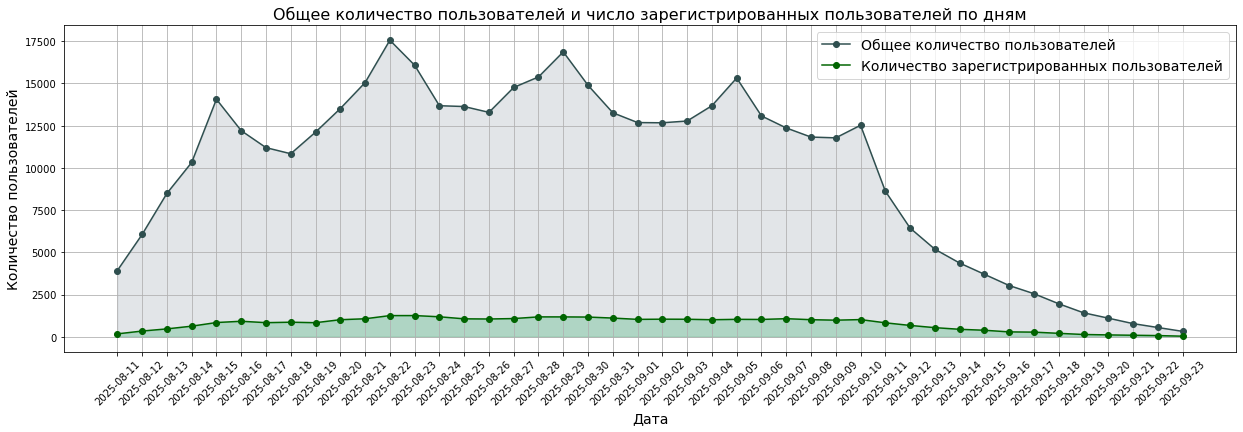

In [8]:
plt.figure(figsize=(21, 6))

plt.plot(registrations['session_date'],
         registrations['dau_total'],
         label='Общее количество пользователей',
         marker='o',
         color='darkslategrey'
        )

plt.plot(registrations['session_date'],
         registrations['dau_registered'],
         label='Количество зарегистрированных пользователей',
         marker='o',
         color='darkgreen'
        )

# Закрасим область под линией общего количества пользователей
plt.fill_between(registrations['session_date'],
                 registrations['dau_total'],
                 color="slategrey", alpha=0.2)

# Закрасим область под линией количества зарегистрированных пользователей
plt.fill_between(registrations['session_date'],
                 registrations['dau_registered'],
                 color="mediumseagreen", alpha=0.3)

plt.xticks(rotation=45)
plt.title('Общее количество пользователей и число зарегистрированных пользователей по дням',
           fontsize=16)
plt.ylabel('Количество пользователей',
           fontsize=14)
plt.xlabel('Дата',
           fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

На графике видим кратный рост общего количества пользователей в первые 2 недели периода, после чего началось плавное снижение.   
Отчетливо виден паттер роста активности с понедельника до пиковых значений по пятницам.   
С 10 сентября началось резкое снижение активности.

Теперь взглянем на линейный график доли зарегистрированных пользователей по дням.

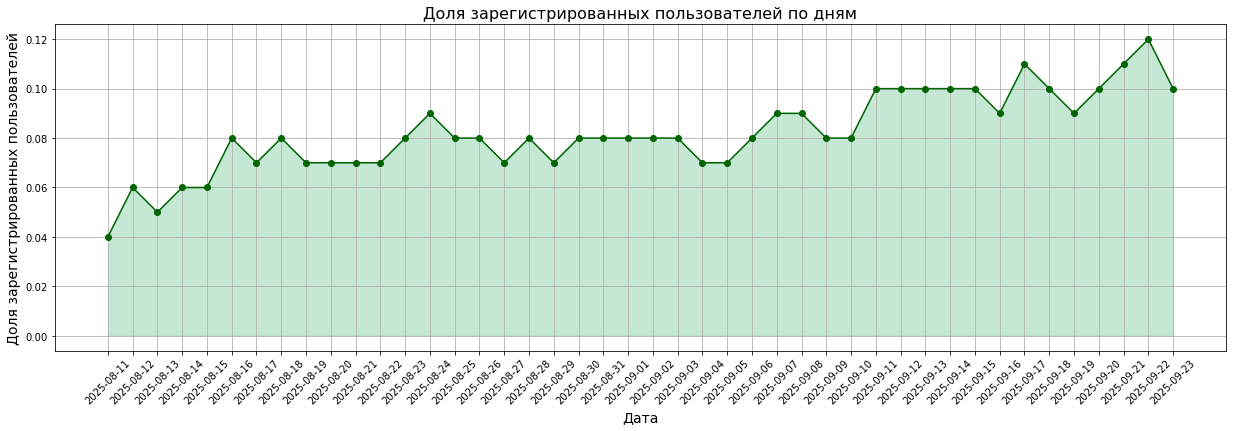

In [9]:
plt.figure(figsize=(21, 6))

plt.plot(registrations['session_date'],
         registrations['dau_registered_rate'],
         label='Доля зарегистированных пользователей',
         marker='o',
         color='darkgreen'
        )

plt.fill_between(registrations['session_date'],
                 registrations['dau_registered_rate'],
                 color="mediumseagreen", alpha=0.3)

plt.xticks(rotation=45,
          ticks=range(0, len(registrations), 1)
         )
plt.xlabel('Дата',
           fontsize=14
          )
plt.ylabel('Доля зарегистрированных пользователей',
           fontsize=14)
plt.title('Доля зарегистрированных пользователей по дням',
           fontsize=16)
plt.grid()
plt.show()

Видим относительно равномерную тенденцию к росту доли зарегистрированных пользователей на протяжении рассматриваемого периода.

---

## 1.4. Анализ числа просмотренных страниц

* Найдем количество сессий для каждого значения количества просмотренных страниц и построим визуализацую

In [10]:
# Сгруппируем данные по значению количества просмотренных страниц, считаем количество сессий
sessions = sessions_history.groupby(['page_counter']).agg(total_sessions=('session_id', 'count')).reset_index()

# Выводим полученну таблицу на экран
display(sessions)

,page_counter,total_sessions
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


По этим данным построим столбчатую диаграмму количества сессий в разрезе числа просмотренных страниц.

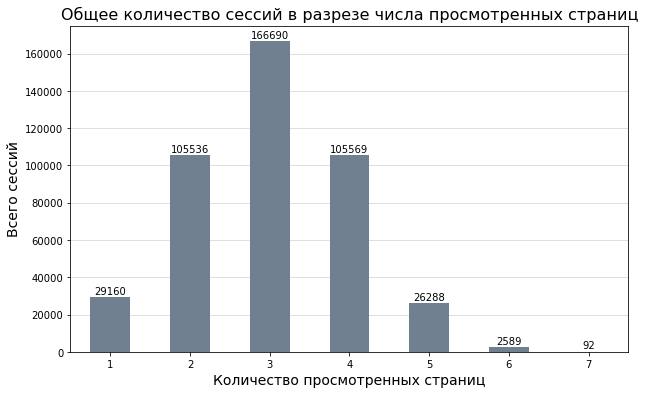

In [11]:
ax = sessions.plot(kind='bar',
              x='page_counter',
              y='total_sessions',
              figsize=(10, 6),
              legend=False,
              color='slategrey',
              zorder=2
             )

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=1, fontsize=10)

plt.xticks(rotation=0)
plt.title('Общее количество сессий в разрезе числа просмотренных страниц',
          fontsize=16
         )
plt.xlabel('Количество просмотренных страниц',
           fontsize=14
          )
plt.ylabel('Всего сессий',
           fontsize=14
          )
plt.grid(axis='y',
         alpha=0.5
        )
plt.show()

* Наблюдаем, что наиболее распространены сессии с 2-4 просмотрами.

---

## 1.5. Доля пользователей, просмотревших более четырёх страниц

Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.  
Исследуем подробнее этот показатель и построим визуализацию.

In [12]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [13]:
# Создадим столбец 'good_session', значение в котором будет равно 1 при 4 и более просмотренных страницах и 0 в обратном случае
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

Теперь построим линейный график среднего значения успешных сессий по дням за период наблюдения.

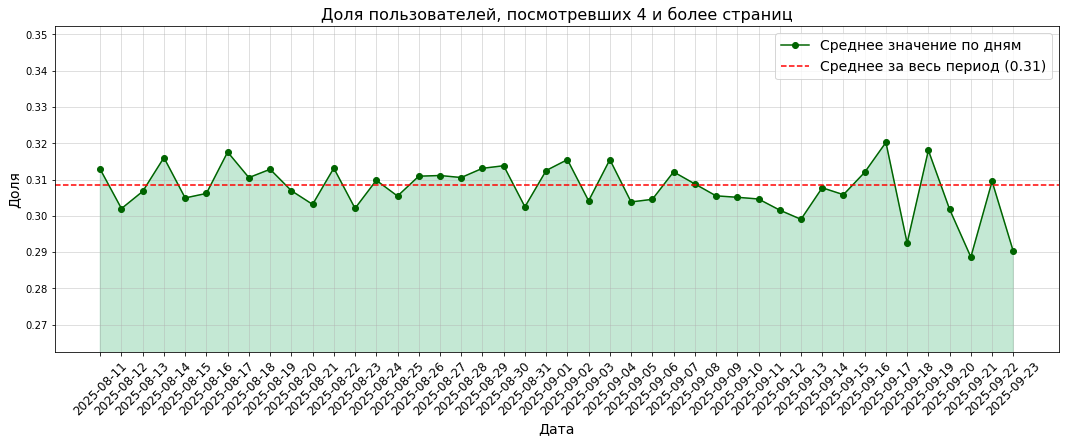

In [14]:
# Для получения доли пользователей с 4 и более просмотренными страницами найдем среднее значение столбца 'good_session' по дням
avg = sessions_history.groupby(['session_date'])['good_session'].mean().reset_index()

avg_total = sessions_history['good_session'].mean()

plt.figure(figsize=(18, 6))

plt.plot(avg['session_date'],
         avg['good_session'],
         marker='o',
         label='Среднее значение по дням',
         color='darkgreen'
        )

# Закрасим область под линией средних значений
plt.fill_between(avg['session_date'],
                 avg['good_session'],
                 color='mediumseagreen',
                 alpha=0.3
                )

plt.ylim(min(avg['good_session']) / 1.1, max(avg['good_session']) * 1.1)

# Добавим на график горизонтальную линию со средним значением доли успеншых сессий за весь период
plt.axhline(y=avg_total,
            color='red',
            linestyle='--',
            label=f'Среднее за весь период ({avg_total:.2f})'
          )

plt.grid(True,
         alpha=0.5
        )
plt.title('Доля пользователей, посмотревших 4 и более страниц',
          fontsize=16
         )
plt.xlabel('Дата',
           fontsize=14)
plt.ylabel('Доля',
           fontsize=14)
plt.legend(fontsize=14)
plt.xticks(rotation=45,
           fontsize=12)
plt.show()

Видим, что доля успешных сессий за период наблюдений была относительно стабильна: колебания были в идентичных диапазонах. После 10 сентября диапазон колебаний заметно увеличился, можно это связать с уменьшением расчетной базы: в это же время началось снижение количества пользователей.

---

# 2. Подготовка к тесту

* Сформулируем нулевую и альтернативную гипотезы
* Выберем целевую метрику.
* Рассчитаем необходимый размер выборки.
* Исходя из текущих значений трафика рассчитем необходимую длительность проведения теста.

---

## 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы.

**Нулевая гипотеза**: если применить новый алгоритм, показывающий пользователям более интересный контент, доля пользователей, посмотревших 4 и более страниц не изменится.   
**Альтернативная гипотеза**: если применить новый алгоритм, показывающий пользователям более интересный контент, доля пользователей, посмотревших 4 и более страниц изменится в большую или меньшую сторону.

---

## 2.2. Расчёт размера выборки

In [15]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


---

## 2.3. Расчёт длительности A/B-теста

* Рассчитаем среднее количество уникальных пользователей приложения в день.

* Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения.

In [16]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = int(round(sessions_history.groupby('session_date')['user_id'].nunique().mean(), 0))

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(2 * sample_size / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


---

# 3. Мониторинг А/В-теста

## 3.1. Проверка распределения пользователей

На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

* Считаем и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.
* Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.
* Рассчитаем процентную разницу в количестве пользователей в группах A и B. Построим визуализацию, на которой будет видно возможное различие двух групп.

In [17]:
# Загружаем исторические данные о сессиях пользователях из CSV-файла в датафрейм 'sessions_test_part'
sessions_test_part = pd.read_csv('sessions_project_test_part.csv')

# Выведем на экран первые 5 строк
display(sessions_test_part.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [18]:
# Посчитаем количество уникальных пользователей в обеих группах, для этого сгруппируем данные
# по тестовым группам 
avg_users = sessions_test_part.groupby('test_group').agg(
    users_count=('user_id', 'nunique')).reset_index()

# Выведем на экран полученную таблицу
display(avg_users)

,test_group,users_count
0,A,1477
1,B,1466


In [19]:
# Рассчитаем процентную разницу в количестве пользователей обеих групп
A = avg_users.loc[avg_users['test_group'] == 'A', 'users_count'].values[0]
B = avg_users.loc[avg_users['test_group'] == 'B', 'users_count'].values[0]
avg_users_diff = round(100 * abs(A - B) / A, 2)

print(f"Разница в количестве пользоваталей в группах A и B составила {avg_users_diff}% ")

Разница в количестве пользоваталей в группах A и B составила 0.74% 


Визуализируем полученные данные с помощью круговой диаграммы

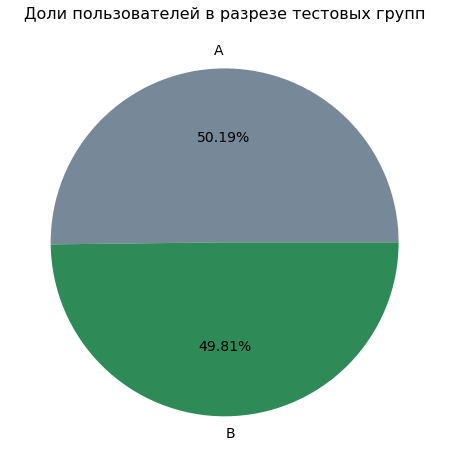

In [20]:
colors = ['lightslategrey', 'seagreen']
plt.figure(figsize=(14, 8))

plt.pie(avg_users['users_count'],
        labels=avg_users['test_group'],
        autopct='%1.2f%%',
        colors=colors,
        textprops={'fontsize': 14}
        )

plt.title('Доли пользователей в разрезе тестовых групп',
          fontsize=16
         )
plt.show()

* Разница в количестве пользователей тестовых групп несущественна.

---

## 3.2. Проверка пересечений пользователей

Помимо проверки равенства количества пользователей в группах убедимся в том, что группы независимы. Для этого нужно проверить, что никто из пользователей случайно не попал в обе группы одновременно.

Создадим датафрейм **`test_users`**, в который поместим все уникальные **`user_id`** пользователей обеих тестовых групп, столбец с принадлажностью пользователя определенной группе и тип устройства.

In [21]:
# Группируем данные по тестовым группам и id пользователей, методом .first() оставим только первое встречающееся значение
# это нужно по причине повтора значений типа устройства из-за возможных нескольких сессий одного пользователя
test_users = sessions_test_part.groupby(['test_group', 'user_id'], as_index=False).first()[['user_id', 'test_group', 'device']]

С помощью метода `isin()` проверим тестовые группы на возможные пересечения по **`user_id`**.

In [22]:
intersection = test_users[test_users['test_group'] == 'A'].isin(test_users[test_users['test_group'] == 'B'])['user_id'].sum()

print(f'В группах A и B одновременно присутсвует {intersection} пользователей.')

В группах A и B одновременно присутсвует 0 пользователей.


Пересечений нет, группы сформированы корректно.

---

## 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:
* доля каждого типа устройства для пользователей из группы A,
* доля каждого типа устройства для пользователей из группы B.

In [23]:
len_a = len(test_users[test_users['test_group'] == 'A'])

for device in test_users[test_users['test_group'] == 'A']['device'].unique():
    device_rate = 100 * round(test_users[(test_users['test_group'] == 'A') & (test_users['device'] == device)].shape[0] / len_a, 2)
    print(f"В тестовой группе А доля пользовтелей с устройством {device}: {device_rate}%")

В тестовой группе А доля пользовтелей с устройством iPhone: 20.0%
В тестовой группе А доля пользовтелей с устройством PC: 25.0%
В тестовой группе А доля пользовтелей с устройством Android: 44.0%
В тестовой группе А доля пользовтелей с устройством Mac: 11.0%


In [24]:
len_b = len(test_users[test_users['test_group'] == 'B'])

for device in test_users[test_users['test_group'] == 'B']['device'].unique():
    device_rate = 100 * round(test_users[(test_users['test_group'] == 'B') & (test_users['device'] == device)].shape[0] / len_b, 2)
    print(f"В тестовой группе B доля пользовтелей с устройством {device}: {device_rate}%")

В тестовой группе B доля пользовтелей с устройством PC: 26.0%
В тестовой группе B доля пользовтелей с устройством Android: 46.0%
В тестовой группе B доля пользовтелей с устройством iPhone: 18.0%
В тестовой группе B доля пользовтелей с устройством Mac: 10.0%


Для визуализации выберем горизонтальную столбчатую диаграмму, значения отсортируем по возрастанию.   
Перейдем к построению графика.

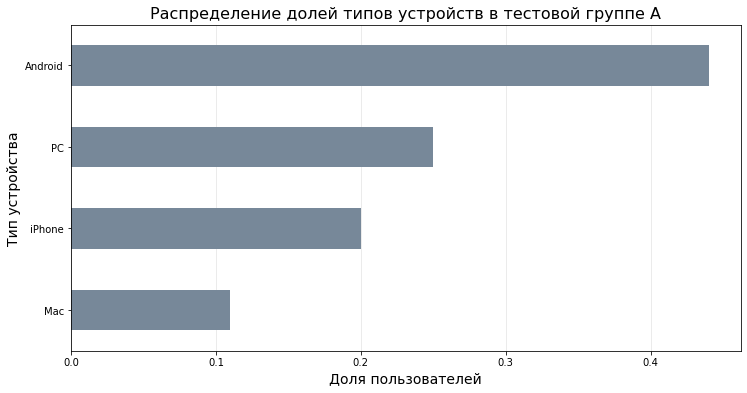

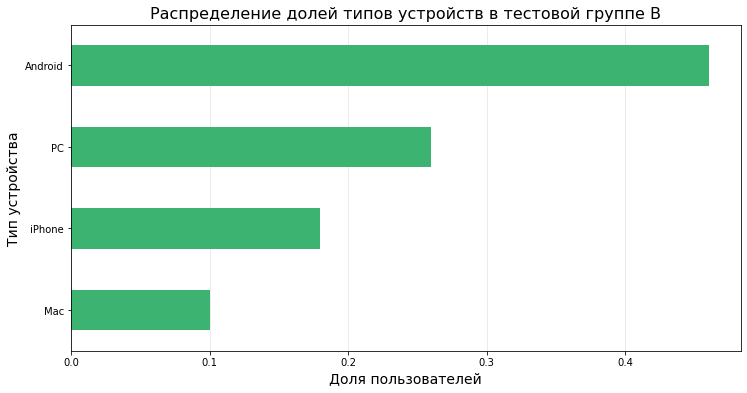

In [25]:
# Группируем данные по типу устройства, считаем количество пользователей
group_a = test_users[test_users['test_group'] == 'A'].groupby('device').agg(
    users_count=('user_id', 'nunique')
).reset_index()
group_b = test_users[test_users['test_group'] == 'B'].groupby('device').agg(
    users_count=('user_id', 'nunique')
).reset_index()

# Считаем доли каждого типов устройств
group_a['share'] = round(group_a['users_count'] / len_a, 2)
group_b['share'] = round(group_b['users_count'] / len_b, 2)

# Сортируем по возрастанию значений долей
group_a = group_a.sort_values(by='share', ascending=True)
group_b = group_b.sort_values(by='share', ascending=True)

group_a.plot(kind='barh',
             x='device',
             y='share',
             color='lightslategrey',
             legend=False,
             zorder=2,
             figsize=(12, 6)
            )
plt.title('Распределение долей типов устройств в тестовой группе A',
           fontsize=16)
plt.xlabel('Доля пользователей',
           fontsize=14)
plt.ylabel('Тип устройства',
           fontsize=14
          )
plt.grid(axis='x',
         alpha=0.3)
plt.show()

group_b.plot(kind='barh',
             x='device',
             y='share',
             color='mediumseagreen',
             legend=False,
             zorder=2,
             figsize=(12, 6)
            )

plt.title('Распределение долей типов устройств в тестовой группе B',
           fontsize=16)
plt.xlabel('Доля пользователей',
           fontsize=14)
plt.ylabel('Тип устройства',
           fontsize=14)
plt.grid(axis='x',
         alpha=0.3)
plt.show()

По графикам видим, что распределение по типам устройств в обеих группах идентичное, но не равномерное: так, присутсвует более чем четырехкратное преимущество устройств на Android перед пользователями Mac.

---

## 3.4. Равномерность распределения пользователей по регионам

Теперь убедитесь, что пользователи равномерно распределены по регионам.

Построим две диаграммы:
* доля каждого региона для пользователей из группы A,
* доля каждого региона для пользователей из группы B.

In [26]:
# Добавим к использованному ранее датафрейму 'test_users' столбец с регионом пользователя, объединяем по 'user_id'
test_users = test_users.merge(sessions_test_part.groupby(['test_group', 'user_id'], as_index=False).first()[['user_id', 'region']],
                              on='user_id',
                              how='left'
                             )

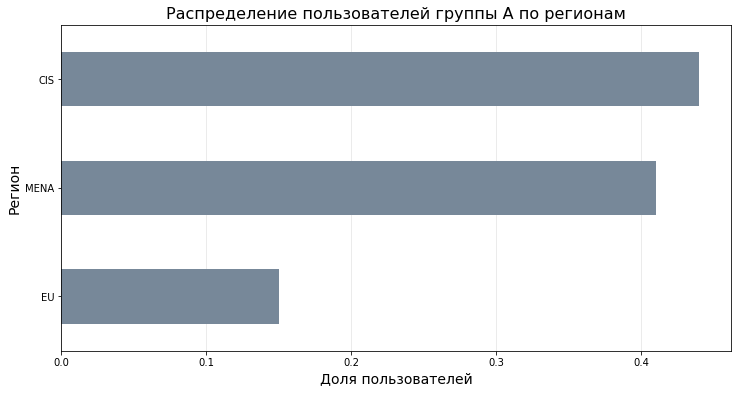

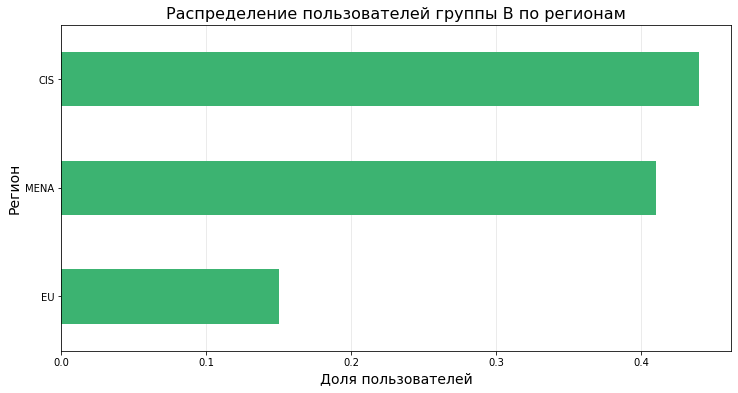

In [27]:
# Группируем данные по региону, считаем количество пользователей
group_a = test_users[test_users['test_group'] == 'A'].groupby('region').agg(
    users_count=('user_id', 'nunique')
).reset_index()
group_b = test_users[test_users['test_group'] == 'B'].groupby('region').agg(
    users_count=('user_id', 'nunique')
).reset_index()

# Считаем доли
group_a['share'] = round(group_a['users_count'] / len_a, 2)
group_b['share'] = round(group_b['users_count'] / len_b, 2)

# Сортируем данные по возрастанию значений долей
group_a = group_a.sort_values(by='share', ascending=True)
group_b = group_b.sort_values(by='share', ascending=True)

group_a.plot(kind='barh',
             x='region',
             y='share',
             color='lightslategrey',
             legend=False,
             zorder=2,
             figsize=(12, 6)
            )
plt.title('Распределение пользователей группы А по регионам',
           fontsize=16)
plt.xlabel('Доля пользователей',
           fontsize=14)
plt.ylabel('Регион',
           fontsize=14)
plt.grid(axis='x',
         alpha=0.3)
plt.show()

group_b.plot(kind='barh',
             x='region',
             y='share',
             color='mediumseagreen',
             legend=False,
             zorder=2,
             figsize=(12, 6)
            )
p
plt.title('Распределение пользователей группы B по регионам',
           fontsize=16)
plt.xlabel('Доля пользователей',
           fontsize=14)
plt.ylabel('Регион',
           fontsize=14
          )
plt.grid(axis='x',
         alpha=0.3)
plt.show()

Получили распределение по регионам, также как и по типам устройств, неравномерное, но идентичное для двух групп.

---

## 3.5. Вывод после проверки A/B-теста

По проведенному анализу А/В-теста можно дать следующие выводы:
* ✅ группы проверены по распределению пользователей: их количество различается на 0.74%, что некритично
* ✅ группы проверены на пересечение пользователей: пересечения отсутсвуют
* ✅ группы проверены на равномеронсть распределения по типу устройств и регионам: распределения идентичные

А/В тест проходит корректно, нарушений не наблюдается.

---

# 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

## 4.1. Получение результатов теста и подсчёт основной метрики

* Прочитаем и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.
* В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [28]:
# Загружаем исторические данные о сессиях пользователях из CSV-файла в датафрейм 'sessions_test'
sessions_test = pd.read_csv('sessions_project_test.csv')

# Выведем на экран первые 5 строк
display(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


Добавим столбец **`good_session`** с индикатором успешных сессий, где количество просмотренных страниц равно 4 или более.

In [29]:
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

---

## 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

* Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.
* Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми.

В **`session_count`** сохраним рассчитанное для теста количество уникальных сессий, сгруппированное по дням и тестовым группам.

In [30]:
# Группируем данные по тестовым группам и датам, считаем уникальное количество сессий
sessions_count = sessions_test.groupby(['test_group', 'session_date']).agg(
    sessions_count=('session_id', 'nunique')
).reset_index()

display(sessions_count.head())

,test_group,session_date,sessions_count
0,A,2025-10-14,1502
1,A,2025-10-15,2235
2,A,2025-10-16,3280
3,A,2025-10-17,4089
4,A,2025-10-18,5013


Расчетным путем получили длительность эксперимента в 9 дней, зададим даты начала и окончания теста.

In [31]:
start_date = sessions_count.iloc[0]['session_date']
end_date = sessions_count.iloc[0+8]['session_date']

Перейдем к проведению теста.
Нулевая гипотеза будет утверждать, что средние между группами равны на генеральной совокупности.
Тогда альтернативная гипотеза будет утверждать, что между группами не равны на генеральной совокупности.   
Проведем статистический t-тест Уэлча.

In [32]:
# Разделяем данные по двум выборкам, оставляем только информацию за 9 дней
test_group_1 = sessions_count[(sessions_count['test_group'] == 'A') &
                              (sessions_count['session_date'] >= start_date) &
                              (sessions_count['session_date'] <= end_date)
                             ]['sessions_count']
test_group_2 = sessions_count[(sessions_count['test_group'] == 'B') &
                              (sessions_count['session_date'] >= start_date) &
                              (sessions_count['session_date'] <= end_date)]['sessions_count']

alpha = 0.05

stat_welch_ttest, p_value_welch_ttest = st.ttest_ind(
    test_group_1, 
    test_group_2, 
    equal_var=False,
    alternative='two-sided' 
)

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')

p-value теста Уэлча = 0.92
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


Чтобы исключить возможное влияние выбросов на результат тестирования, дополнительно выполним тест Манна-Уитни.

In [33]:
alpha = 0.05
mw_test = mannwhitneyu(
    test_group_1,
    test_group_2,
    alternative='two-sided'
)
if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Распределения метрики в группах A и B различаются')

pvalue=0.859819205054158 > 0.05
Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны


По результату t-теста Уэлча получили значение `p-value` выше уровня статистической значимости. Таким образом, можем утверждать, что средние значения количества уникальных сессий равны. Различия между ними не являются статистически значимыми.

---

## 4.3. Сравнение доли успешных сессий

Можно переходить к анализу ключевой метрики — доли успешных сессий.

Используем созданный ранее столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе.

In [34]:
# Группируем данные по тестовым группам, считаем количество успешных сессий, ограничиваем данные 5-ю днями
good_sessions_total = sessions_test[(sessions_test['session_date'] >= start_date) &
                                   (sessions_test['session_date'] <= end_date)
                                  ].groupby('test_group').agg(
    good_session_count=('good_session', 'sum'),
    total_sessions=('session_id', 'nunique')
).reset_index()

# Считаем доли успешных сессий
good_sessions_total['rate'] = round(good_sessions_total['good_session_count'] / good_sessions_total['total_sessions'], 2)

# Считаем разницу в количестве успешных сессий между двумя группами
a_good_sessions = good_sessions_total.loc[good_sessions_total['test_group'] == 'A', 'good_session_count'].iloc[0]
b_good_sessions = good_sessions_total.loc[good_sessions_total['test_group'] == 'B', 'good_session_count'].iloc[0]
good_sessions_diff = abs(a_good_sessions - b_good_sessions)

In [35]:
display(good_sessions_total)
good_sessions_diff_a = 100 * round(good_sessions_diff / a_good_sessions, 4) 
good_sessions_diff_b = 100 * round(good_sessions_diff / b_good_sessions, 4)
print(f"Разница в количестве успешных сессий между двумя группами {good_sessions_diff}.")
print(f"Что составляет {good_sessions_diff_a}% от успешных сессий выборки A и {good_sessions_diff_b}% от успешных сессий выборки B.")

,test_group,good_session_count,total_sessions,rate
0,A,10954,35501,0.31
1,B,11529,36225,0.32


Разница в количестве успешных сессий между двумя группами 575.
Что составляет 5.25% от успешных сессий выборки A и 4.99% от успешных сессий выборки B.


Взглянем на разницу в доле успешных сессий, построив столбчатую диаграмму

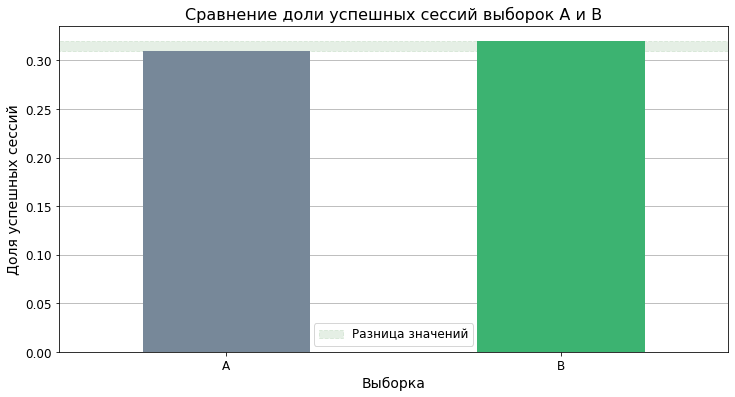

In [36]:
good_sessions_total.plot(kind='bar',
                         x='test_group',
                         y='rate',
                         color=['lightslategrey', 'mediumseagreen'],
                         zorder=2,
                         figsize=(12, 6),
                         label=''
                        )

# Посколько разница между значениями небольшая, выделим ее цветом по уровням максимального и минимального значений
plt.axhspan(
    ymin=min(good_sessions_total['rate']),
    ymax=max(good_sessions_total['rate']),
    color='darkgreen',
    alpha=0.1,
    linestyle='--',
    zorder=1,
    label='Разница значений'
)

plt.grid(axis='y')
plt.xticks(rotation=0,
           fontsize=12
          )
plt.yticks(fontsize=12)
plt.title('Сравнение доли успешных сессий выборок A и B',
          fontsize=16
         )
plt.xlabel('Выборка',
           fontsize=14
          )
plt.ylabel('Доля успешных сессий',
           fontsize=14
          )
plt.legend(fontsize=12)
plt.show()

Видим разницу в долях в размере 1% в пользу контрольной выборки. Теперь необходимо определить, являются ли положительные изменения статистически значимыми.

---

## 4.4. Насколько статистически значимо изменение ключевой метрики

Проведем статистический тест по значениям столбца с долями успешных сессий (**`rate`**). Выясним, являются ли изменения статистически значимыми.   
За нулевую гипотезу возьмем вывод, что изменения в доле таких сессий не произошли (не являются статистически значимыми).   
При альтернативной гипотезе рост метрики превысил уровень статистической значимости.   
Так как сравниваем доли, воспоьзуемся Z-тестом пропорций.

In [37]:
# Берем значения количества успешных сессий в выборках A и B
m_a = good_sessions_total[good_sessions_total['test_group'] == 'A']['good_session_count']
m_b = good_sessions_total[good_sessions_total['test_group'] == 'B']['good_session_count']

# Берем значения по общему количеству сессий выборок A и B
n_a = good_sessions_total[good_sessions_total['test_group'] == 'A']['total_sessions']
n_b = good_sessions_total[good_sessions_total['test_group'] == 'B']['total_sessions']

alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=[0.00254221] < 0.05
Нулевая гипотеза не находит подтверждения!


В результате статистического теста отвергли нулевую гипотезу о том, что доля успешных не изменилась во второй выборке.   
Таким образом, в контрольной выборке рост доли успешных сессий превысил уровень статистической значимости.

---

## 4.5. Вывод по результатам A/B-эксперимента

A/B-тестирование проведено успешно. В ходе эксперимента получили следующие данные и результаты:
* рассчитали, что для эксперимента потребуются выборки по `41040 пользователей`
* с траффиком в `9907 ежедневных пользователей` эксперимент занял `9 дней`
* пользователи в выборках равномерно распределены по долям типов устройств и регионов
* получили значение `p-value = 0.0025`, что ниже статистической значимости `alpha = 0.05`, таким образом отвергли нулевую гипотезу и определили, что внедрение нового алгоритма рекомендаций оказало положителный эффект на рост ключевой метрики — доля сессий с 4 и более просмотренными страницами выросла
* прежде чем внедрять нововведение в приложение, будет полезно провести дополнительные исследования по прокси-метрикам и барьерным метрикам, например:
    * доля пользователей, смотревших 1, 2 или 3 страницы или количество зарегистрированных за день пользователей в качестве прокси-метрик
    * частота сбоев и ошибок в приложении в качестве барьерной метрики